## 8. LinkNet with Resnet

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

### 8.1 Loading Data

In [3]:
path = '/content/drive/MyDrive/cs2/'

In [5]:
#loading train and validation data
train_data = pd.read_csv(path + "data/train_data.csv").fillna('')
validtn_data = pd.read_csv(path + "data/validtn_data.csv").fillna('')

### 8.2 Data Generator Implementation

In [6]:
# Implementing custom data generator
#https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, num_classes=None, shuffle=True, preprocess=None):
        self.batch_size = batch_size
        self.df = dataframe
        self.indices = self.df.index.tolist()
        self.preprocess = preprocess
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // (self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True,
                 'width_shift_range':0.1, 'height_shift_range':0.1,}
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32) # image place-holders
        Y = np.empty((self.batch_size,256,1600,4),dtype=np.float32)# 4 masks place-holders
              
        for i, id in enumerate(batch):
          img = Image.open(path+'data/train_images/' + str(self.df['ImageId'].loc[id]))
          X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)#input image
          for j in range(4): #looping for each class
                mask = rle2mask(self.df['rle_'+str(j+1)].loc[id])
                Y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)#mask for each class
                
        # preprocess input
        if self.preprocess!=None: X = self.preprocess(X)

        return X, Y

### 8.3 Utility Functions

In [7]:
#https://www.kaggle.com/titericz/building-and-visualizing-masks
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

#defining function for converting EncodedPixels(rle: run length encoding) to mask
def rle2mask(rle_string, img_shape=(256,1600)):
    '''
    input: EncodedPixels (run-length-encoded) string & image shape:-(width,height)
    output: mask in numpy.ndarray format with shape (256,1600)
    '''
    rle_array = np.array([int(s)for s in rle_string.split()])
    starts_array = rle_array[::2]-1
    lengths_array = rle_array[1::2]
    mask_array = np.zeros(img_shape[0]*img_shape[1],dtype=np.uint8)
    #print(starts_array,lengths_array)
    for i in range(len(starts_array)):
        mask_array[starts_array[i]:starts_array[i]+lengths_array[i]] = 1
    #order='F' because encoded pixels are numbered from top to bottom, then left to right
    return mask_array.reshape(img_shape, order = 'F')

#defining function for converting given mask to EncodedPixels(rle: run length encoding)
def mask2rle(mask_array):
    '''
    input: mask in numpy.ndarray format
    output: EncodedPixels (run-length-encoded) string
    '''
    mask_array = mask_array.T.flatten()
    mask_array = np.concatenate([[0], mask_array, [0]])
    rle_array = np.where(mask_array[1:]!=mask_array[:-1])[0]+1
    rle_array[1::2] -= rle_array[::2]
    rle_string = ' '.join(map(str,rle_array))
    return rle_string

#defining function for calculation of metric dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    smoothing_const = 1e-9
    return (2. * intersection + smoothing_const) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smoothing_const)

#defining function for calculation of dice coefficient
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return (1-dice_coefficient(y_true, y_pred))

#defining function for calculation of loss function: binary cross entropy + dice loss
def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return binary_crossentropy(y_true, y_pred) + (1-dice_coefficient(y_true, y_pred))

### 8.4 Defining Linknet Architecture with ResNet as backbone

In [19]:
# defining Linknet architecture with Resnet as backbone
# https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/models/linknet.py
# https://medium.com/@nishanksingla/unet-with-resblock-for-semantic-segmentation-dd1766b4ff66
# https://github.com/Nishanksingla/UNet-with-ResBlock/blob/master/resnet34_unet_model.py
# https://github.com/hlamba28/UNET-TGS

def ResBlock(input_tensor, n_filters, kernel_size = 3, batchnorm = True ):
    """function to pass Input_tensor through Resnet block configured as per the input parameters"""

    # Residual/Skip connection
    res = Conv2D(filters = n_filters, kernel_size=(1,1),\
               kernel_initializer = 'he_normal', padding='same')(input_tensor)

    # first Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # second Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)

    resconnection = Add()([res, x])
    x = Activation('relu')(resconnection)

    return x


def linknet_withResnet_Model(input_image, n_filters = 16, batchnorm = True):
    # Encoder (Contraction Path)
    E1 = ResBlock(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(E1)
    #p1 = Dropout(dropout)(p1)

    E2 = ResBlock(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(E2)
    #p2 = Dropout(dropout)(p2)

    E3 = ResBlock(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(E3)
    #p3 = Dropout(dropout)(p3)

    E4 = ResBlock(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(E4)
    #p4 = Dropout(dropout)(p4)

    E5 = ResBlock(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Decoder (Expansive Path)
    D6 = Conv2DTranspose(n_filters * 8, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(E5)
    D6 = Add()([D6, E4])
    #D6 = Dropout(dropout)(D6)
    E6 = ResBlock(D6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    D7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(E6)
    D7 = Add()([D7, E3])
    #D7 = Dropout(dropout)(D7)
    E7 = ResBlock(D7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    D8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(E7)
    D8 = Add()([D8, E2])
    #D8 = Dropout(dropout)(D8)
    E8 = ResBlock(D8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    D9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(E8)
    D9 = Add()([D9, E1])
    #D9 = Dropout(dropout)(D9)
    E9 = ResBlock(D9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(4, (1, 1), activation='sigmoid')(E9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [20]:
input_img = Input((256, 1600, 3), name='img')
model = linknet_withResnet_Model(input_img, n_filters=8, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coefficient])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 256, 1600, 8) 224         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 1600, 8) 32          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 1600, 8) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [10]:
#loading train & validation data using DataGenerator class defined
train_batches = DataGenerator(train_data,shuffle=True)
validtn_batches = DataGenerator(validtn_data,shuffle=False)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime, os

# #tensorboard for visualizing loss & metric summary 
# logdir = path+"logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(logdir)

#defining ModelCheckpoint to make a checkpoint when validation dice coefficient improves
checkpoints = ModelCheckpoint(path+'linknet_withResnet.h5' , monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

#adding ModelCheckpoint & TensorBoard to callback functions list
callbacks_list = [checkpoints]

### 8.5 Traing Model (1-30 epochs)

In [ ]:
# fit model
history = model.fit(train_batches,validation_data=validtn_batches, epochs = 30, callbacks=callbacks_list)

Epoch 1/30
333/333 [==============================] - 4648s 14s/step - loss: 5.6820 - dice_coefficient: 0.0148 - val_loss: 1.2927 - val_dice_coefficient: 0.0213

Epoch 00001: val_dice_coefficient improved from -inf to 0.02135, saving model to /content/drive/MyDrive/cs2/linknet_withResnet.h5
Epoch 2/30
333/333 [==============================] - 546s 2s/step - loss: 1.2450 - dice_coefficient: 0.0223 - val_loss: 1.1401 - val_dice_coefficient: 0.0389

Epoch 00002: val_dice_coefficient improved from 0.02135 to 0.03889, saving model to /content/drive/MyDrive/cs2/linknet_withResnet.h5
Epoch 3/30
333/333 [==============================] - 546s 2s/step - loss: 1.1289 - dice_coefficient: 0.0339 - val_loss: 1.1252 - val_dice_coefficient: 0.0598

Epoch 00003: val_dice_coefficient improved from 0.03889 to 0.05978, saving model to /content/drive/MyDrive/cs2/linknet_withResnet.h5
Epoch 4/30
333/333 [==============================] - 545s 2s/step - loss: 1.0191 - dice_coefficient: 0.1059 - val_loss: 2

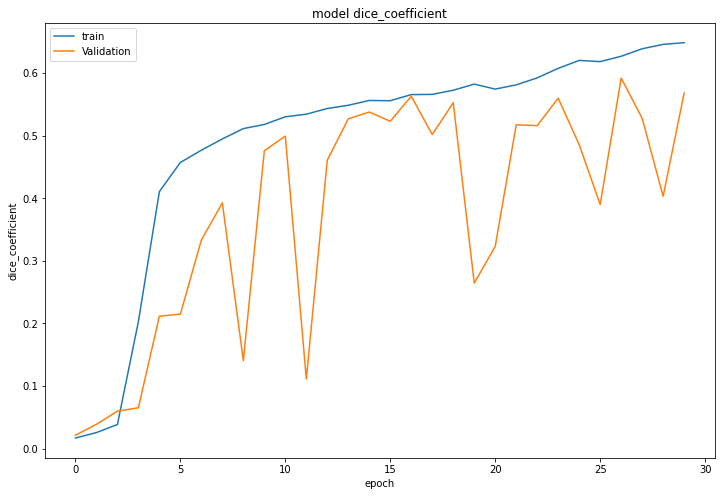

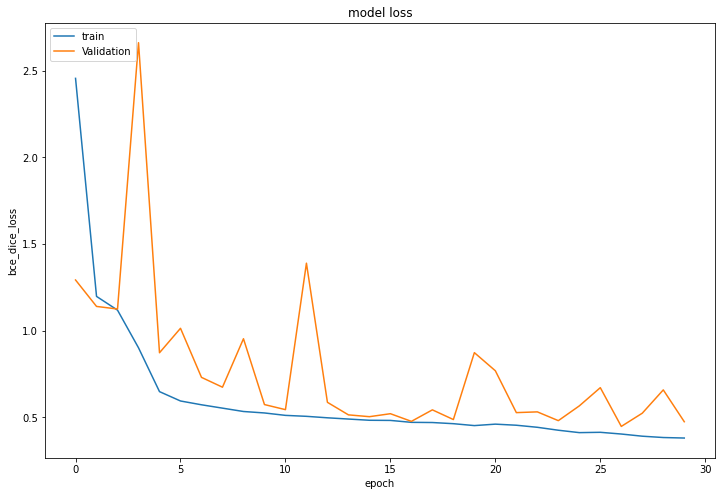

In [ ]:
# Visualizing history for dice_coefficient
plt.figure(figsize=(12, 8))
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('model dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# Visualizing history for loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('bce_dice_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# saving history data for first 30 epochs in csv file
history1 = pd.DataFrame(history.history)
history1.to_csv(path + "data/history1-linknet_withResnet.csv", index=True)
# saving model(weights upto 30 epochs)
model.save(path+'linknet_withResnet-30epochs.h5')

### 8.6 Traing Model (30-60 epochs)

In [ ]:
#loading saved weights of model trained upto 30 epochs
model.load_weights(path + 'linknet_withResnet-30epochs.h5')
# fit model
history = model.fit(train_batches,validation_data=validtn_batches, epochs = 30, callbacks=callbacks_list)

Epoch 1/30
333/333 [==============================] - 5762s 17s/step - loss: 0.3804 - dice_coefficient: 0.6484 - val_loss: 0.4371 - val_dice_coefficient: 0.6040

Epoch 00001: val_dice_coefficient improved from -inf to 0.60404, saving model to /content/drive/MyDrive/cs2/linknet_withResnet.h5
Epoch 2/30
333/333 [==============================] - 995s 3s/step - loss: 0.3714 - dice_coefficient: 0.6571 - val_loss: 0.4813 - val_dice_coefficient: 0.5626

Epoch 00002: val_dice_coefficient did not improve from 0.60404
Epoch 3/30
333/333 [==============================] - 995s 3s/step - loss: 0.3561 - dice_coefficient: 0.6709 - val_loss: 0.6725 - val_dice_coefficient: 0.4044

Epoch 00003: val_dice_coefficient did not improve from 0.60404
Epoch 4/30
333/333 [==============================] - 994s 3s/step - loss: 0.3630 - dice_coefficient: 0.6649 - val_loss: 0.4358 - val_dice_coefficient: 0.6002

Epoch 00004: val_dice_coefficient did not improve from 0.60404
Epoch 5/30
333/333 [===================

In [ ]:
# saving history data for 31-60 epochs in csv file
history2 = pd.DataFrame(history.history)
history2.to_csv(path + "data/history2-linknet_withResnet.csv", index=True)
# saving model(weights upto 60 epochs)
model.save(path+'linknet_withResnet-31-60epochs.h5')

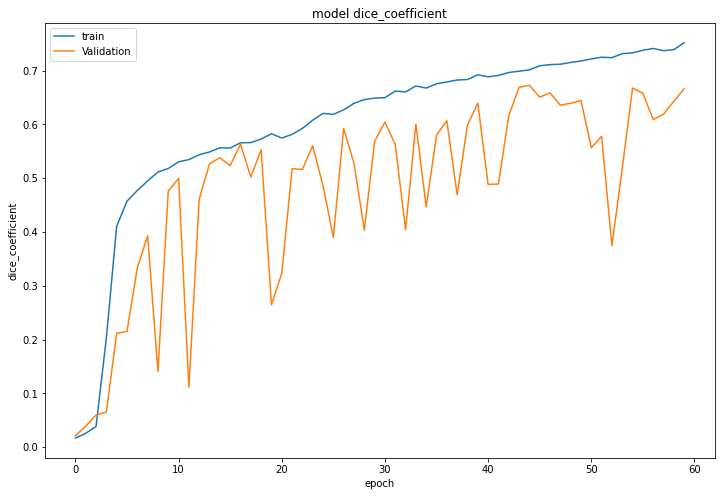

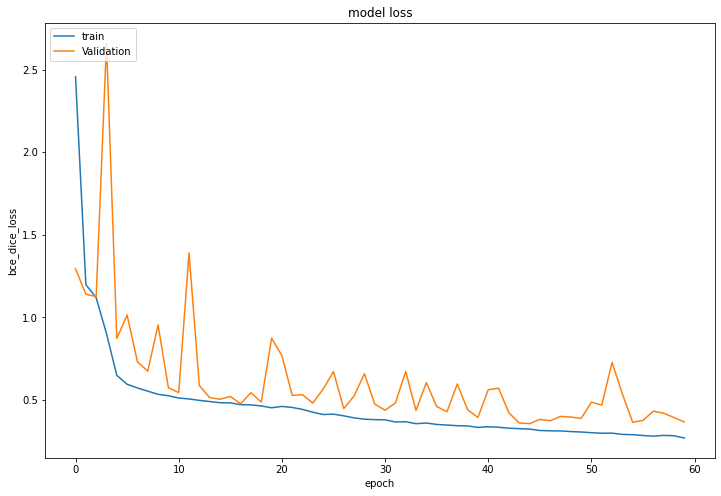

In [7]:
#loading saved history of 1-30 epochs
history1 = pd.read_csv(path + "data/history1-linknet_withResnet.csv")
#loading saved history of 30-60 epochs
history2 = pd.read_csv(path + "data/history2-linknet_withResnet.csv")

# Visualizing history(1-60 epochs) for dice_coefficient
plt.figure(figsize=(12, 8))
plt.plot(history1['dice_coefficient'].tolist() + history2['dice_coefficient'].tolist())
plt.plot(history1['val_dice_coefficient'].tolist() + history2['val_dice_coefficient'].tolist())
plt.title('model dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# Visualizing history(1-60 epochs) for loss
plt.figure(figsize=(12, 8))
plt.plot(history1['loss'].tolist() + history2['loss'].tolist())
plt.plot(history1['val_loss'].tolist() + history2['val_loss'].tolist())
plt.title('model loss')
plt.ylabel('bce_dice_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

### 8.7 Visualizing Model Predictions

In [21]:
# evaluating model(best weights) with the validation batch
model.load_weights(path + 'linknet_withResnet.h5')
loss, dc= model.evaluate(validtn_batches,verbose=1)
print('loss:',loss, 'dice_coefficient:',dc)

58/58 [==============================] - 856s 14s/step - loss: 0.3498 - dice_coefficient: 0.6787
loss: 0.3561689257621765 dice_coefficient: 0.672707200050354


In [22]:
#defining function to display GroundTruth & Predicted mask images for a given imageId
def visualize_model_prediction(img_id):
    fig, axs = plt.subplots(4, 3, figsize=(16,8))
    img_obj = cv2.imread(path+'data/train_images/'+ img_id)
    masks_actual = full_data[full_data['ImageId'] == img_id]
    x = np.empty((1,256,1600,3),dtype=np.float32) # image place-holders
    x[0,] = Image.open(path+'data/train_images/' + img_id)
    masks_predicted = model.predict(x)
    for i in range(4):
        axs[i,0].imshow(img_obj)
        axs[i,0].set_title(img_id)
        axs[i,1].imshow(rle2mask(masks_actual['rle_'+str(i+1)].iloc[0]))
        axs[i,1].set_title("Actual mask for Class '{}'".format(i+1) )
        axs[i,2].imshow(masks_predicted[0,:,:,i])
        axs[i,2].set_title("Predicted mask for Class '{}'".format(i+1))
    plt.show()

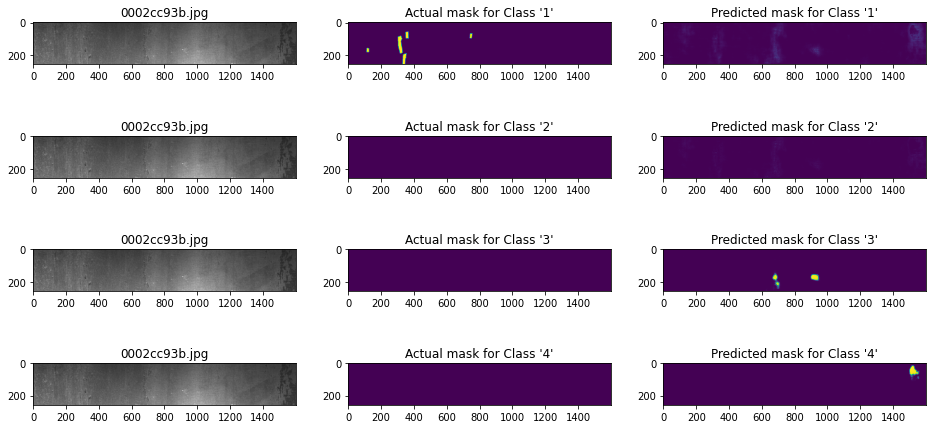

In [23]:
visualize_model_prediction('0002cc93b.jpg')

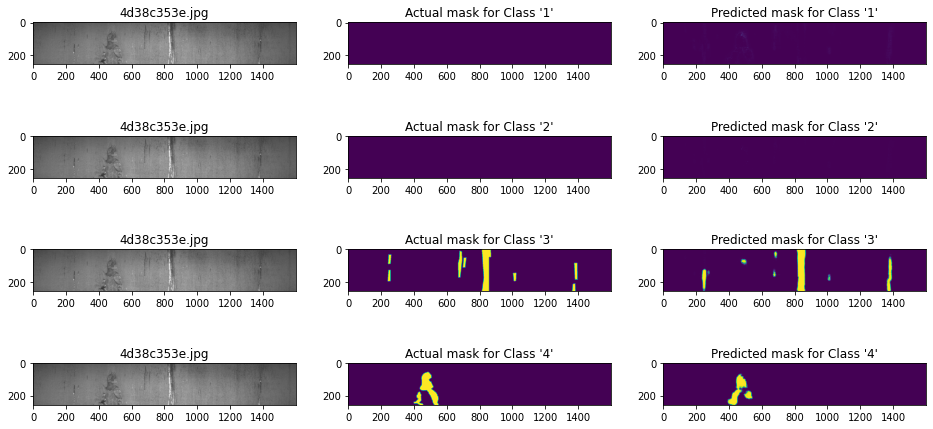

In [24]:
visualize_model_prediction('4d38c353e.jpg')

### 8.8 Preparing Data for submission

In [25]:
class PredictDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,dataframe, list_idcs, batch_size=32, ):
        self.batch_size = batch_size
        self.df = dataframe
        self.list_idcs = list_idcs
        self.indices = self.df.index.tolist()
        self.rem = len(self.list_idcs) % (self.batch_size)
        self.on_epoch_end()

    def __len__(self):
         return len(self.list_idcs) // (self.batch_size)
#         if (self.rem) == 0:
#             return len(self.list_idcs) // (self.batch_size)
#         else:
#             return (len(self.list_idcs) // (self.batch_size) )+1

    def __getitem__(self, index):
        index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
#         if ((index + 1) * self.batch_size) < len(self.list_idcs):
#             index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
#         else:
#             index = self.indices[index * self.batch_size: (index * self.batch_size)+ self.rem]
        batch = [self.list_idcs[k] for k in index]
        
        X = self.__get_data(batch)
         
        return X
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))

    def __get_data(self, batch):
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32) # image place-holders
              
        for i, id in enumerate(batch):
          img = Image.open(path + 'data/test_images/' + str(self.df['ImageId'].loc[id]))
          X[i,] = img#input image

        return X

In [26]:
test_img_IDs = list(os.listdir(path + 'data/test_images/'))
test_imgsIds_df = pd.DataFrame({'ImageId': test_img_IDs})
print(len(test_imgsIds_df))
test_imgsIds_df.head()

5506


,ImageId
0,d3dcedbd7.jpg
1,db7cff638.jpg
2,d3764cee5.jpg
3,d387d301f.jpg
4,d221d2a3f.jpg


In [27]:
SubmissionDf = pd.DataFrame(columns = ['ImageId','EncodedPixels','ClassId'])

In [28]:
for i in range(0,len(test_imgsIds_df),320):
    batch_idcs =  list(range(i, min(test_imgsIds_df.shape[0], i + 320)))#.iloc[batch_idcs]
    if len(batch_idcs)== 320:        
        test_subbatch = PredictDataGenerator(dataframe = test_imgsIds_df,
                                             list_idcs = batch_idcs)
    else:
        test_subbatch = PredictDataGenerator(dataframe = test_imgsIds_df,
                                             list_idcs = batch_idcs,
                                             batch_size= len(batch_idcs))
    #print(len(test_subbatch))
    subbatch_pred_masks = model.predict(test_subbatch)
    #print(len(subbatch_pred_masks))
    #break
    for j, idx in tqdm(enumerate(batch_idcs)):
        filename = test_imgsIds_df['ImageId'].iloc[idx]
        rle1 = mask2rle(subbatch_pred_masks[j,:,:,0].round().astype(int))
        rle2 = mask2rle(subbatch_pred_masks[j,:,:,1].round().astype(int))
        rle3 = mask2rle(subbatch_pred_masks[j,:,:,2].round().astype(int))
        rle4 = mask2rle(subbatch_pred_masks[j,:,:,3].round().astype(int))
        df = pd.DataFrame({'ImageId':[filename]*4,
                      'EncodedPixels': [rle1,rle2,rle3,rle4],
                      'ClassId':['1', '2', '3', '4']})
        SubmissionDf = SubmissionDf.append(df,ignore_index=True)

320it [00:03, 82.35it/s]
320it [00:04, 68.53it/s]
320it [00:04, 67.76it/s]
320it [00:04, 67.64it/s]
320it [00:04, 68.45it/s]
320it [00:04, 67.87it/s]
320it [00:04, 68.06it/s]
320it [00:04, 71.14it/s]
320it [00:04, 68.20it/s]
320it [00:04, 68.32it/s]
320it [00:04, 68.02it/s]
320it [00:04, 69.36it/s]
320it [00:04, 67.87it/s]
320it [00:04, 68.65it/s]
320it [00:04, 68.23it/s]
320it [00:04, 68.30it/s]
320it [00:04, 68.33it/s]
66it [00:00, 67.21it/s]


In [29]:
SubmissionDf.sort_values(by=['ImageId', 'ClassId'], inplace=True)
SubmissionDf['ImageId_ClassId'] = SubmissionDf['ImageId'] + '_' + SubmissionDf['ClassId']
print(SubmissionDf.shape)
SubmissionDf.head(10)

(22024, 4)


,ImageId,EncodedPixels,ClassId,ImageId_ClassId
20016,0000f269f.jpg,,1,0000f269f.jpg_1
20017,0000f269f.jpg,,2,0000f269f.jpg_2
20018,0000f269f.jpg,145887 5 145893 1 145911 1 145913 4 146027 1 1...,3,0000f269f.jpg_3
20019,0000f269f.jpg,,4,0000f269f.jpg_4
20004,000ccc2ac.jpg,,1,000ccc2ac.jpg_1
20005,000ccc2ac.jpg,,2,000ccc2ac.jpg_2
20006,000ccc2ac.jpg,,3,000ccc2ac.jpg_3
20007,000ccc2ac.jpg,374594 1 374845 8 375099 1 375102 3 375106 1 3...,4,000ccc2ac.jpg_4
20012,002451917.jpg,,1,002451917.jpg_1
20013,002451917.jpg,,2,002451917.jpg_2


In [30]:
SubmissionDf.to_csv(path+'submission-linknet_withResnet.csv', index=False)

In [ ]:
# dot_img_file = '/tmp/model_1.png'
# tf.keras.utils.plot_model(model2, to_file=dot_img_file, show_shapes=True)

### 8.9 Kaggle Submission Score

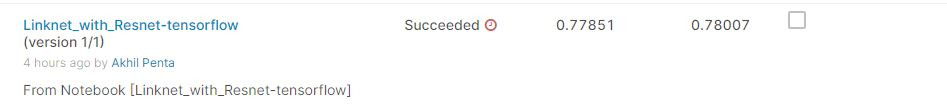

In [1]:
#Kaggle Score
from IPython.display import Image
Image(filename='linknet with resnet.JPG') 